In [1]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed

# Set up the system path to include parent directory
sys.path.append('../../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)



if __name__ == "__main__":
    configure_logging()
    df = load_data('../../Data/Validation_set/USPTO_50K.csv')

# **1. SynExtract**

Here's a brief description of how we can approach the task:

1. **Input and Parsing of Chemical Reactions**: The script will accept chemical reactions as input. Each reaction will be a string where reactants and products are separated by an arrow (e.g., A + B -> C + D). The script will parse these strings to identify reactants and products.

2. **Standardization of Chemical Formulas**: The script will standardize the chemical formulas to ensure consistency. This involves formatting element symbols and quantities properly.

3. **Decomposition into Molecular Formulas**: Each reactant and product will be broken down into its molecular formula. For example, decomposing H2O into {'H': 2, 'O': 1}.

4. **Labeling Types of Reactions**:

    - **Balance Check**: The script will check if the reaction is balanced by comparing the count of each element on both sides of the reaction.
    - **Labeling**: Based on the balance check, reactions will be labeled as:
        - **Balanced**: If the number of each type of atom is the same on both sides.
        - **Unbalanced in Reactants**: If any reactant element is not balanced.
        - **Unbalanced in Products**: If any product element is not balanced.
        - **Unbalanced in Both**: If elements in both reactants and products are unbalanced.

## **1.1. Extract SMILES**

In [2]:
from SynRBL.SynProcessor import RSMIProcessing
process = RSMIProcessing(data=df, data_name='USPTO_50K', rsmi_col='reactions', parallel=True, n_jobs=10, 
                            save_json =False, save_path_name= '../../Data/reaction.json.gz')
reactions = process.data_splitter().to_dict('records')
reactions[0]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 5120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.6s finished


{'id': 'US05849732',
 'class': 6,
 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'R-id': 'USPTO_50K_0'}

# **1.2. Check Carbon Balance**

In [3]:
from SynRBL.SynProcessor import CheckCarbonBalance
check = CheckCarbonBalance(reactions, rsmi_col='reactions', symbol='>>', atom_type='C', n_jobs=4)
reactions = check.check_carbon_balance()
reactions[0]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 116 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 48917 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 49702 out of 49702 | elapsed:    4.1s finished


{'id': 'US05849732',
 'class': 6,
 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'R-id': 'USPTO_50K_0',
 'carbon_balance_check': 'products'}

In [5]:
rules_based = [reactions[key] for key, value in enumerate(reactions) if value['carbon_balance_check'] == 'balanced']
mcs_based = [reactions[key] for key, value in enumerate(reactions) if value['carbon_balance_check'] != 'balanced']
print(len(rules_based), len(mcs_based))

35944 13758


## **1.3. Molecular Decomposer**

In [6]:
from SynRBL.SynProcessor import RSMIDecomposer  
decompose = RSMIDecomposer(smiles=None, data=rules_based, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()
react_dict[0]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 16392 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 35944 out of 35944 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 30109 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 35944 out of 35944 | elapsed:    1.3s finished


{'N': 4, 'C': 19, 'O': 4, 'S': 2, 'Cl': 2, 'H': 12}

## **1.4. Molecular Comparator**

In [7]:
from SynRBL.SynProcessor import RSMIComparator
from SynRBL.SynUtils.data_utils import save_database, load_database
import pandas as pd

In [8]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel(reactants= react_dict, products=product_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 32079 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 35944 out of 35944 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 33064 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 35944 out of 35944 | elapsed:    0.1s finished


## **1.5. Both side reactions rules**

In [9]:
from SynRBL.SynProcessor import BothSideReact
both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= both_side.fit()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 2700 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 2928 out of 2947 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 2947 out of 2947 | elapsed:    0.1s finished


In [10]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')
reactions_clean[0]

{'id': 'US05849732',
 'class': 6,
 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'R-id': 'USPTO_50K_0',
 'carbon_balance_check': 'products',
 'Unbalance': 'Products',
 'Diff_formula': {'O': 1, 'H': 2}}

# **2. SynRuleEngine - Rule Generation**

## **2.1. Manual Rules Extraction**

In [56]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, sort_by_key_length
from SynRBL.SynRuleImputer.rule_data_manager import RuleImputeManager
   

rules = []
former_len = len(rules)
db = RuleImputeManager(rules)

entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

rules = filter_data(db.database, formula_key='Composition', element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(db.database, lambda x: x['Composition'])

rules

Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[21:40:31] SMILES Parse Error: syntax error while parsing: Invalid
[21:40:31] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


[{'formula': 'CO2',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}}]

## **2.2. Automatic rule extraction**

In [68]:
from SynRBL.SynRuleImputer.auto_extract_smiles import AutomaticSmilesExtraction
from SynRBL.SynRuleImputer.auto_extract_rules import AutomaticRulesExtraction

# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions_clean, n_jobs=4, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=500, n_C=0, combination='intersection')
print("Filtered Fragments:", len(filtered_fragments))


extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
automated_rules = extractor.extract_rules()
print("Extracted Rules:", len(automated_rules))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 134024 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 134781 out of 134781 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s


Filtered Fragments: 3


[Parallel(n_jobs=4)]: Done 134781 out of 134781 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Entry with formula 'H3N' and smiles 'N' added to the database.
Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'N3-' and smiles '[N-]=[N+]=[N-]' added to the database.
Entry with formula 'H4N2' and smiles 'NN' added to the database.
Entry with formula 'HO4S-' and smiles 'O=S([O-])OO' added to the database.
Entry with formula 'H3NO' and smiles 'NO' added to the database.
Entry with formula 'H4N+' and smiles '[NH4+]' added to the database.
Entry with formula 'HI' and smiles 'I' added to the database.
Entry with formula 'H2O2' and smiles 'OO' added to the database.
Entry with formula 'H4N2O2S' and smiles 'NS(N)(=O)=O' added to the database.
Entry with formula 'HBr' and smiles 'Br' added to the database.
Entry with formula 'HClO3S' and smiles 'O=S(=O)(O)Cl' added to the database.
Entry with formula 'HCl' and smiles 'Cl' added to the database.
Entry with formula 'Cl2O2S' and smiles 'O=S(=O)(Cl)Cl' added to the database.
Entry with formula 'H2ClNO2S' and smi

[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1182 out of 1182 | elapsed:    0.9s finished


# **3. SynRuleImpute**


## **3.1. Rule-based Imputation**

In [11]:
from SynRBL.SynUtils.data_utils import save_database, load_database, filter_data, extract_results_by_key
from SynRBL.SynRuleImputer import SyntheticRuleImputer

rules = load_database('../../Data/Rules/rules_manager.json.gz')
#reactions_clean = load_database('../../Data/reaction_clean.json.gz')

# Filter data based on specified criteria

balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Balanced Reactions:', len(balance_reactions))

unbalance_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Unbalanced Reactions in one side:', len(unbalance_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

Number of Balanced Reactions: 1074
Number of Unbalanced Reactions in one side: 32102
Number of Both sides Unbalanced Reactions: 2768


In [12]:
# Configure RDKit logging
from rdkit import Chem
import rdkit
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Initialize SyntheticRuleImputer and perform parallel imputation
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(unbalance_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))



# Combine all unsolved cases
unsolve = both_side_reactions + unsolve
print('Total unsolved:', len(unsolve))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  49 tasks      | elapsed:    0.4s


Solved: 32002
Unsolved in rules based method: 100
Total unsolved: 2868


[Parallel(n_jobs=-2)]: Done 27942 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done 32102 out of 32102 | elapsed:    1.9s finished


## **3.2. Uncertainty Reaction**

In [13]:
from SynRBL.rsmi_utils import  save_database, load_database
from SynRBL.SynRuleImputer.synthetic_rule_constraint import RuleConstraint
constrain = RuleConstraint(solve, ban_atoms=['[H]','[O].[O]', 'F-F', 'Cl-Cl', 'Br-Br', 'I-I', 'Cl-Br', 'Cl-I', 'Br-I'])
certain_reactions, uncertain_reactions = constrain.fit()

id_uncertain = [entry['R-id'] for entry in uncertain_reactions]
new_uncertain_reactions = [entry for entry in reactions_clean if entry['R-id'] in id_uncertain]

unsolve = unsolve + new_uncertain_reactions


for d in unsolve:
    d.pop('Unbalance', None)  # Remove 'Unbalance' key if it exists
    d.pop('Diff_formula', None)  # Remove 'Diff_formula' key if it exists

mcs_based = mcs_based+unsolve

In [14]:
# Save solved and unsolved reactions
#save_database(certain_reactions,  '../../Data/rule_based_reactions.json.gz')
#save_database(mcs_based,  '../../Data/mcs_based_reactions.json.gz')

## **3.2. Visualization**

In [72]:
from SynRBL.SynUtils.data_utils import load_database, get_random_samples_by_key
certain_reactions = load_database('../../Data/Validation_set/USPTO_50K/Solved_reactions.json.gz')
uncertain_reactions = load_database('../../Data/Validation_set/USPTO_50K/Unsolved_reactions.json.gz')
validate_samples = get_random_samples_by_key(certain_reactions, num_samples_per_group=10, random_seed=42, stratify_key = 'Diff_formula')
#save_database(validate_samples, '../../Data/validate_samples.json.gz')
len(validate_samples)


443

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
for i in range(0, 5,1):
    try:
        vis = ReactionVisualizer()
        vis.plot_reactions(uncertain_reactions[i], 'reactions', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)
    except:
        vis = ReactionVisualizer()
        vis.plot_reactions(uncertain_reactions[i], 'reactions', 'reactions', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)


# **4. MCS Rebalancing**

## **4.1. Maximum common substructure**

In [15]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import sys
from pathlib import Path
from SynRBL.SynMCSImputer.SubStructure.mcs_graph_detector import MCSMissingGraphAnalyzer
from SynRBL.SynMCSImputer.SubStructure.mcs_process import single_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from rdkit import Chem
import logging




#unsolve = load_database('../../Data/Validation_set/USPTO_50K/Unsolved_reactions.json.gz')
mcs_results_dict = single_mcs(mcs_based[0])
mcs_results_dict

{'R-id': 'USPTO_50K_0',
 'mcs_results': ['COC(=O)-C(-CCCCN)-NC(=O)-Nc1:c:c(-OC):c:c(-C(-C)(-C)-C):c:1-O'],
 'sorted_reactants': ['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'],
 'issue': [],
 'carbon_balance_check': 'products'}

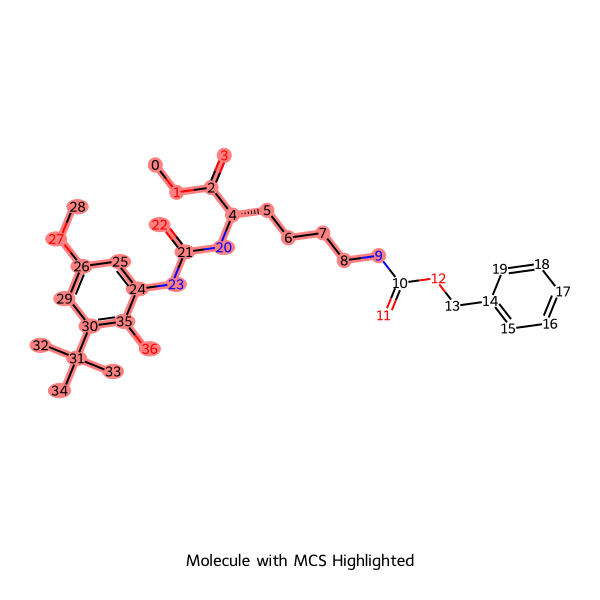

In [16]:
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=False, missing_graph_smiles=None)
img

## **4.2. Find Graph**

Reactants
Neighbor Atom: [[{'N': 9}]]
Missing compounds in Products
Boundary Atom: [[{'C': 1}]]


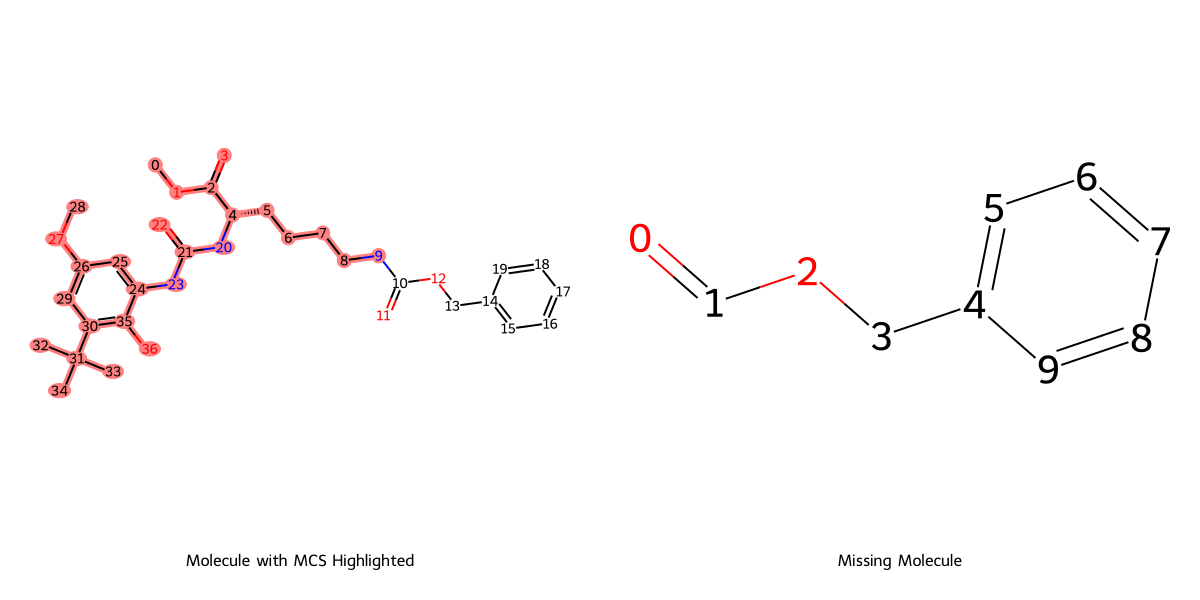

In [17]:
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import FindMissingGraphs
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mol_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['sorted_reactants']]
mcs_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['mcs_results']]

find_graph = FindMissingGraphs()
missing_graph, boundary, neighbor = find_graph.find_missing_parts_pairs(mol_list=mol_list, mcs_list=mcs_list,use_findMCS=True)




print('Reactants')
print('Neighbor Atom:', neighbor)
print('Missing compounds in Products')
print('Boundary Atom:', boundary)

mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=True, missing_graph_smiles=Chem.MolToSmiles(missing_graph[0]))
img


## **4.3. Mol Merge**

## **4.4. Check and Re-Impute by Rule based method**